In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt # graficos

from utils import run_complete_pca, plot_individuals

pd.options.display.max_columns=None

### Configuracion de los datos y la situación analizar

In [2]:
with(open("config.json", "r")) as file:
    config_files = json.load(file)


data_name = config_files["data_name"]
pierna = config_files["pierna"]
situaciones = config_files["situaciones"].copy()
for sitid in situaciones.keys():
    situaciones[sitid]["var_interes"] = situaciones[sitid]["var_interes"].format(pierna=pierna.lower())

sitid = config_files["situacion_analizar"]
var_interes = situaciones[sitid]["var_interes"]
get_min = situaciones[sitid]["min"]


print(f"Se va a trabajar con los datos de: {data_name}; pierna: {pierna}")
print(f"Se va trabajar en la situacion: {situaciones[sitid]}")

Se va a trabajar con los datos de: CYCLONES; pierna: DER
Se va trabajar en la situacion: {'var_interes': 'velocidad_der_vel', 'min': True}


### Lectura de los datos

In [3]:
df = pd.read_csv(f"../datos/{data_name}_PIERNA_{pierna}.csv", sep="|")
print(f"# de registros en el archivo reformateado:{df.shape}")
display(df.head(3))

print("... filtro de la situación de interes")
df_sit = (
    df
    # ordenamos de mayor a menor los datos de cada jugador en cada replica
    .sort_values(["player", "replica", var_interes], ascending=get_min)
    # capturamos el maximo o minimo
    .groupby(["player", "replica"])
    .first()
)
print(f"# de registros en la situación de interes: {df_sit.shape}")
df_sit.head(3)

# de registros en el archivo reformateado:(6363, 23)


,item,player,replica,angulos_rod_der_x,angulos_rod_der_y,angulos_rod_der_z,momentos_rod_der_x,momentos_rod_der_y,momentos_rod_der_z,emg_der_bf,emg_der_st,emg_der_vl,emg_der_vm,hq_der_lat,hq_der_med,frv_der_frv,velocidad_der_vel,talla_m,peso_kg,posicion_de_juego,pierna_habil,lesion_rodilla_ultimos_3_anos,tipo_de_lesion
0,1,JEFFERSON ANGULO,1,48.321899,-4.337573,-8.497101,-0.071115,-0.005196,0.056340,0.153899,0.281727,0.232937,0.494979,0.660687,0.569170,4.023742,3.112761,1.75,72.45,defensa lateral,derecha,no,no
1,1,JEFFERSON ANGULO,2,36.976704,-4.768758,-6.886652,0.055122,-0.013010,0.017787,0.282068,0.293743,0.230157,0.392641,1.225543,0.748122,4.190571,3.056547,1.75,72.45,defensa lateral,derecha,no,no
2,1,JEFFERSON ANGULO,3,53.867855,7.628788,-21.518278,0.060003,-0.011600,0.051897,0.471769,0.244241,0.071327,0.380602,6.614168,0.641722,4.518857,2.899150,1.75,72.45,defensa lateral,derecha,no,no


... filtro de la situación de interes
# de registros en la situación de interes: (63, 21)


item  angulos_rod_der_x  angulos_rod_der_y  \
player       replica                                               
DAIRO BUSTOS 1          60          53.155598          -2.672925   
             2          42          61.888020           2.325140   
             3          41          54.430668           0.505015   

                      angulos_rod_der_z  momentos_rod_der_x  \
player       replica                                          
DAIRO BUSTOS 1                 4.992381            0.271022   
             2                 6.950686            0.266855   
             3                13.970980            0.276795   

                      momentos_rod_der_y  momentos_rod_der_z  emg_der_bf  \
player       replica                                                       
DAIRO BUSTOS 1                 -0.039295            0.036369    0.239700   
             2                  0.072869           -0.021180    0.706295   
             3                  0.072123           -0.007455    0.278003   

                      emg_der_st  emg_der_vl  emg_der_vm  hq_der_lat  \
player       replica                                                   
DAIRO BUSTOS 1          0.153313    0.008408    0.099774   28.506882   
             2          0.019476    0.198050    0.456292    3.566253   
             3          0.078902    0.211186    0.270146    1.316384   

                      hq_der_med  frv_der_frv  velocidad_der_vel  talla_m  \
player       replica                                                        
DAIRO BUSTOS 1          1.536597    19.301424           2.573492     1.75   
             2          0.042683    16.843241           2.065858     1.75   
             3          0.292072    16.964485           2.468009     1.75   

                      peso_kg posicion_de_juego pierna_habil  \
player       replica                                           
DAIRO BUSTOS 1           65.0   defensa central    izquierda   
             2           65.0   defensa central    izquierda   
             3           65.0   defensa central    izquierda   

                     lesion_rodilla_ultimos_3_anos tipo_de_lesion  
player       replica                                               
DAIRO BUSTOS 1                                  no             no  
             2                                  no             no  
             3                                  no             no

### Variables que se van analizar

In [4]:
total_vars = [
    f"emg_{pierna.lower()}_bf",
    f"emg_{pierna.lower()}_st",
    f"emg_{pierna.lower()}_vl",
    f"emg_{pierna.lower()}_vm",
    f"hq_{pierna.lower()}_lat",
    f"hq_{pierna.lower()}_med",
    f"angulos_rod_{pierna.lower()}_x",
    f"angulos_rod_{pierna.lower()}_y",
    f"velocidad_{pierna.lower()}_vel",
    f"momentos_rod_{pierna.lower()}_x",
    f"momentos_rod_{pierna.lower()}_y",
    f"frv_{pierna.lower()}_frv"
]

### Analisis Descriptivo

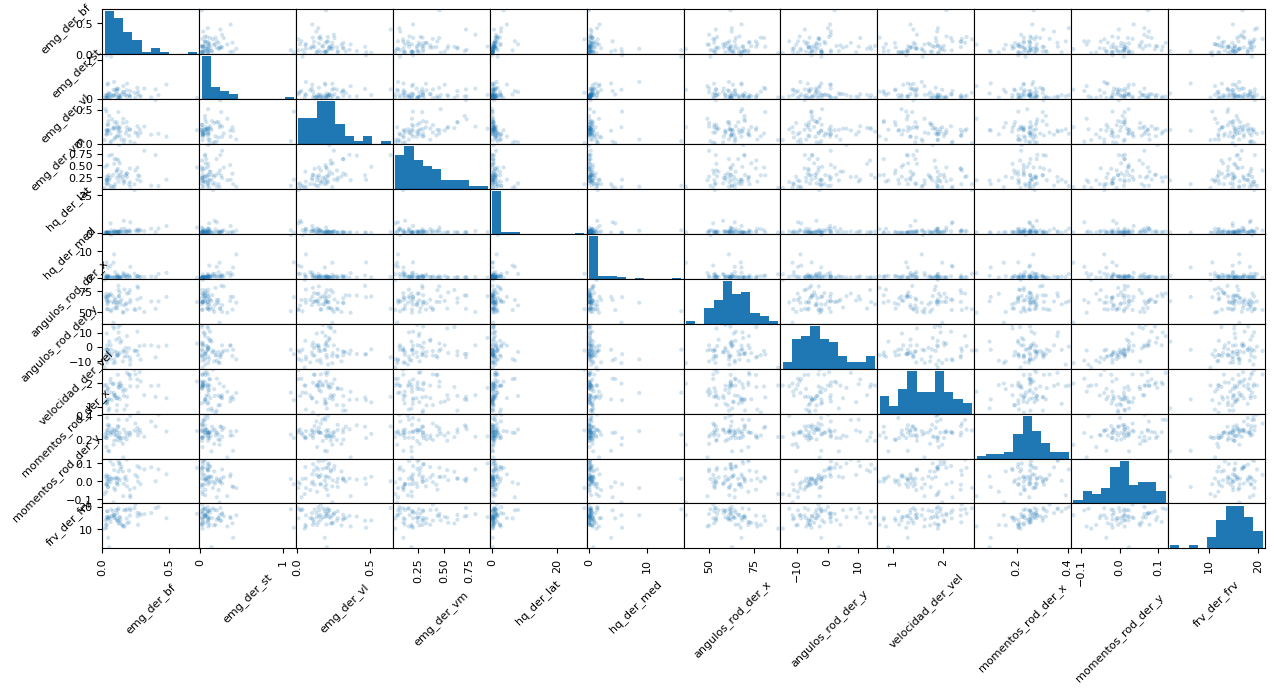

In [5]:
vars_use = total_vars.copy()

_ = pd.plotting.scatter_matrix(
    df_sit.reset_index(drop=True)[vars_use], 
    alpha=0.2, 
    figsize=(15, 7)
)

for ax in _.ravel():
    ax.set_xlabel(ax.get_xlabel(), fontsize=8, rotation = 45)
    ax.set_ylabel(ax.get_ylabel(), fontsize=8, rotation = 45)
plt.show()

In [6]:
corr = df_sit[vars_use].corr(method="spearman")

# Fill diagonal and upper half with NaNs
mask = np.zeros_like(corr, dtype=bool)
mask[np.diag_indices_from(mask)] = True
corr[mask] = np.nan
(
    corr
    .style
    .background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)
    .highlight_null(color='#f1f1f1')  # Color NaNs grey
    .format(precision=2)
)

,emg_der_bf,emg_der_st,emg_der_vl,emg_der_vm,hq_der_lat,hq_der_med,angulos_rod_der_x,angulos_rod_der_y,velocidad_der_vel,momentos_rod_der_x,momentos_rod_der_y,frv_der_frv
emg_der_bf,nan,0.10,-0.15,0.10,0.79,0.03,-0.08,0.12,0.38,0.23,0.26,0.37
emg_der_st,0.10,nan,0.03,-0.07,0.13,0.78,-0.24,-0.18,-0.39,-0.26,-0.26,-0.12
emg_der_vl,-0.15,0.03,nan,0.57,-0.66,-0.32,-0.05,0.03,-0.35,-0.04,0.06,-0.13
emg_der_vm,0.10,-0.07,0.57,nan,-0.25,-0.65,0.11,0.29,-0.25,0.02,0.37,0.00
hq_der_lat,0.79,0.13,-0.66,-0.25,nan,0.27,-0.12,0.05,0.47,0.15,0.14,0.35
hq_der_med,0.03,0.78,-0.32,-0.65,0.27,nan,-0.21,-0.34,-0.14,-0.19,-0.42,-0.11
angulos_rod_der_x,-0.08,-0.24,-0.05,0.11,-0.12,-0.21,nan,0.05,-0.08,0.07,0.12,-0.35
angulos_rod_der_y,0.12,-0.18,0.03,0.29,0.05,-0.34,0.05,nan,0.09,0.02,0.81,0.17
velocidad_der_vel,0.38,-0.39,-0.35,-0.25,0.47,-0.14,-0.08,0.09,nan,0.20,0.16,0.40
momentos_rod_der_x,0.23,-0.26,-0.04,0.02,0.15,-0.19,0.07,0.02,0.20,nan,0.15,0.69


In [7]:
# Recategorizacion de la posicion de juego
def recode_pos_juego(x):
    if "def" in x:
        newx = "defensa"
    elif "ofen" in x:
        newx = "ofensiva"
    elif "delan" in x:
        newx = "ofensiva"
    elif "extr" in x:
        newx = "ofensiva"
    else:
        newx = x
    
    return newx

df_sit["pos_juego_recat"] = [
    recode_pos_juego(x) for x in df_sit["posicion_de_juego"]
]

In [8]:
df_sit = df_sit.reset_index()
df_sit = df_sit.reset_index()

In [9]:
df_sit.head(2)

,index,player,replica,item,angulos_rod_der_x,angulos_rod_der_y,angulos_rod_der_z,momentos_rod_der_x,momentos_rod_der_y,momentos_rod_der_z,emg_der_bf,emg_der_st,emg_der_vl,emg_der_vm,hq_der_lat,hq_der_med,frv_der_frv,velocidad_der_vel,talla_m,peso_kg,posicion_de_juego,pierna_habil,lesion_rodilla_ultimos_3_anos,tipo_de_lesion,pos_juego_recat
0,0,DAIRO BUSTOS,1,60,53.155598,-2.672925,4.992381,0.271022,-0.039295,0.036369,0.239700,0.153313,0.008408,0.099774,28.506882,1.536597,19.301424,2.573492,1.75,65.0,defensa central,izquierda,no,no,defensa
1,1,DAIRO BUSTOS,2,42,61.888020,2.325140,6.950686,0.266855,0.072869,-0.021180,0.706295,0.019476,0.198050,0.456292,3.566253,0.042683,16.843241,2.065858,1.75,65.0,defensa central,izquierda,no,no,defensa


### PCA con todas las variables

Explained variance ratio:  [0.2548652522897903, 0.24728406050325677]
Cumulative explained variance:  [0.25486525 0.50214931]
Transformed data shape: (63, 2)
Circulo de correlaciones de las variables


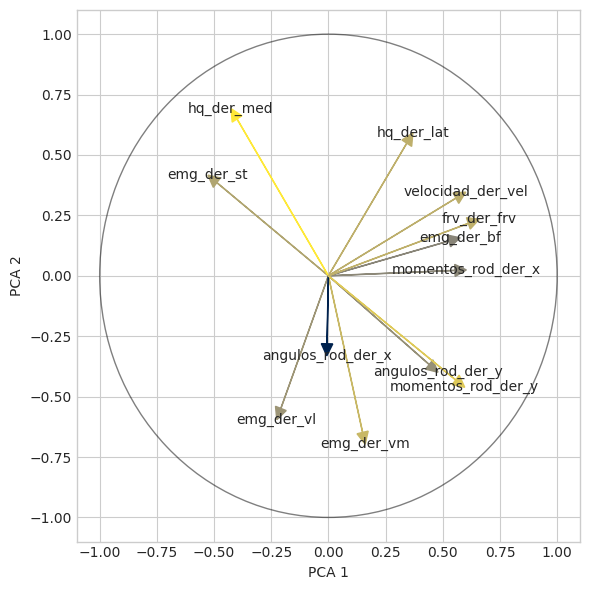

Grafico de las ejecuciones de los movimientos
Color de los puntos de acuerdo con la variable: lesion_rodilla_ultimos_3_anos


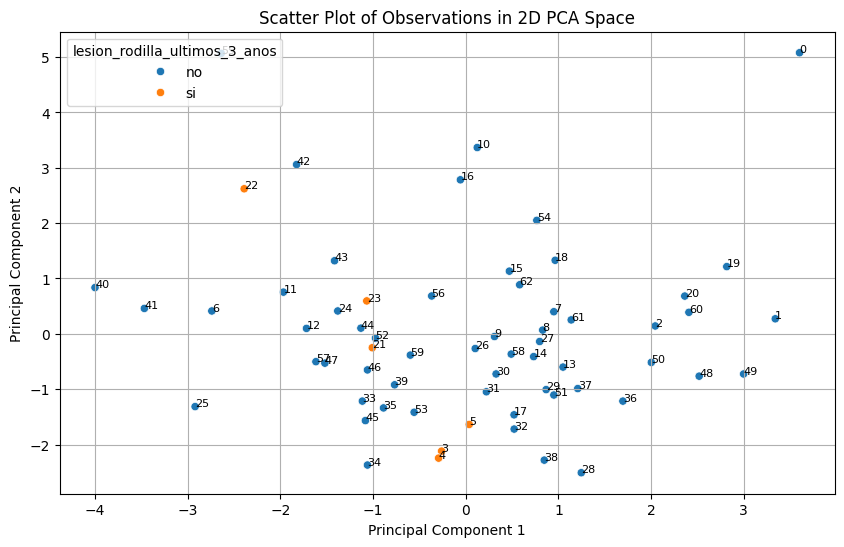

Grafico combinado: variables+movimientos


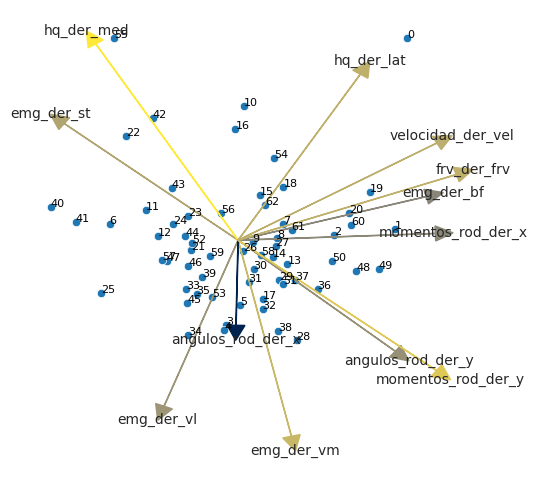

Variables que más contribuyen a PC1:
 ['frv_der_frv', 'velocidad_der_vel', 'momentos_rod_der_y', 'emg_der_bf', 'hq_der_lat', 'momentos_rod_der_x', 'angulos_rod_der_y']


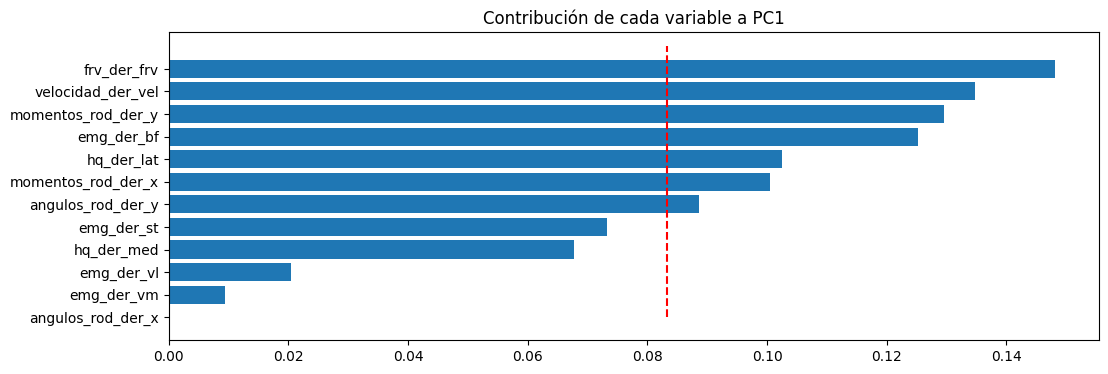

Variables que más contribuyen a PC2:
 ['hq_der_med', 'emg_der_vm', 'hq_der_lat', 'emg_der_vl']


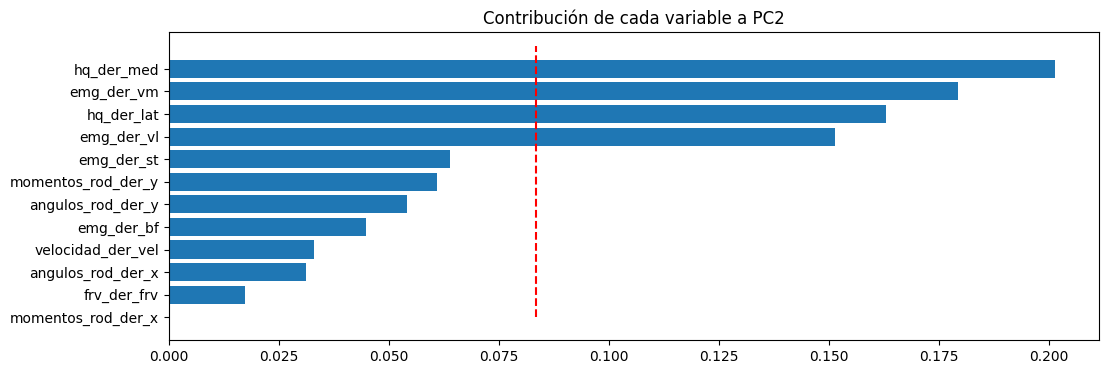

In [10]:
color_var = "lesion_rodilla_ultimos_3_anos"
_ = run_complete_pca(
    data=df_sit, 
    vars_use=vars_use, 
    rowindex=df_sit["index"].tolist(),
    color_var=color_var
)

#### Eliminación de los outliers

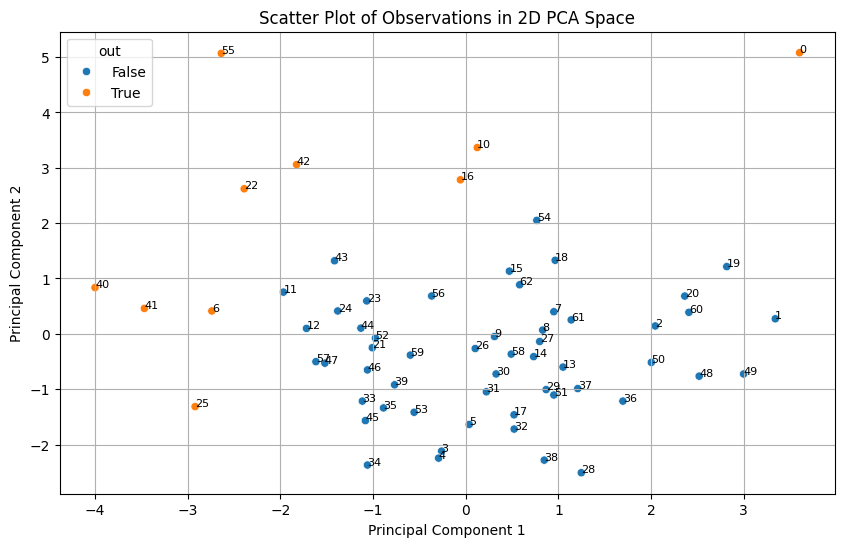

out
False    53
True     10
Name: count, dtype: int64


In [12]:
df_sit["out"] = False
ixout = [
    55, 42, 22, 10, 16, 0, 40, 41, 25, 6
]
df_sit["out"].iloc[ixout] = True
color_var = "out"
color_arr = df_sit[color_var].values
plot_individuals(
    Xpca=_, 
    rowindex=df_sit["index"].tolist(),
    color=color_arr, 
    colorName=color_var
)
print(df_sit["out"].value_counts())

In [13]:
# datos asociados a los outliers
df_sit[df_sit["out"]]

,index,player,replica,item,angulos_rod_der_x,angulos_rod_der_y,angulos_rod_der_z,momentos_rod_der_x,momentos_rod_der_y,momentos_rod_der_z,emg_der_bf,emg_der_st,emg_der_vl,emg_der_vm,hq_der_lat,hq_der_med,frv_der_frv,velocidad_der_vel,talla_m,peso_kg,posicion_de_juego,pierna_habil,lesion_rodilla_ultimos_3_anos,tipo_de_lesion,pos_juego_recat,out
0,0,DAIRO BUSTOS,1,60,53.155598,-2.672925,4.992381,0.271022,-0.039295,0.036369,0.239700,0.153313,0.008408,0.099774,28.506882,1.536597,19.301424,2.573492,1.75,65.00,defensa central,izquierda,no,no,defensa,True
6,6,DIEGO ARNEDO,1,21,49.063622,-2.583297,-5.904952,0.043289,-0.084808,0.031742,0.156056,0.326793,0.367071,0.186309,0.425139,1.754038,11.192570,1.633262,1.77,69.15,volante ofensivo,derecha,no,no,ofensiva,True
10,10,JEFFERSON ANGULO,2,47,64.229958,-9.723506,-4.060981,0.249642,-0.090933,0.033700,0.208571,0.200034,0.029504,0.048897,7.069229,4.090964,18.367080,2.189033,1.75,72.45,defensa lateral,derecha,no,no,defensa,True
16,16,JEREMY VINTEX,2,65,52.217213,-8.678973,1.505068,0.252944,-0.007932,-0.040691,0.060822,0.109163,0.009558,0.023992,6.363653,4.549969,14.808140,2.174756,1.69,59.20,extremo,derecha,no,no,ofensiva,True
22,22,JORGE SAMUEL PUERTO,2,63,37.031052,-11.508550,-0.850642,0.150317,-0.119056,0.012674,0.082562,0.233240,0.241460,0.041533,0.341930,5.614495,16.201521,1.985202,1.78,68.15,defensa central,derecha,si,menisco interno derecha,defensa,True
25,25,JOSE FELIPE MARRUGO,2,101,62.754475,3.681741,-18.919683,0.094677,0.024335,-0.028565,0.050874,0.136448,0.204147,0.182337,0.249201,0.748330,1.941961,0.917780,1.75,65.95,volante ofensivo,derecha,no,no,ofensiva,True
40,40,KLEYBER DE LA ROSA,2,25,67.630180,-5.266536,1.714535,0.207000,-0.018105,-0.004666,0.030603,1.128114,0.473339,0.196889,0.064654,5.729709,10.618135,1.271117,1.77,64.35,defensa central,derecha,no,no,defensa,True
41,41,KLEYBER DE LA ROSA,3,3,67.984177,-2.095482,4.947965,0.099147,-0.034069,0.061478,0.042641,0.396615,0.189963,0.103249,0.224473,3.841328,6.159951,1.303338,1.77,64.35,defensa central,derecha,no,no,defensa,True
42,42,PEDRO LUIS SANCHEZ,1,60,60.997299,-8.931873,19.409681,0.265322,-0.039621,0.010293,0.087227,0.434957,0.060690,0.050096,1.437249,8.682468,16.160354,1.578912,1.63,60.00,volante ofensivo,derecha,no,no,ofensiva,True
55,55,SERGIO ANDRES LENIS,2,53,50.692127,-2.060425,9.260990,0.235462,0.011045,0.020004,0.064543,1.092853,0.036930,0.068766,1.747706,15.892349,18.825612,1.596177,1.73,65.05,defensa lateral,izquierda,no,no,defensa,True


In [14]:
print(df_sit.shape)
df_sit = df_sit[~df_sit["out"]]
print(df_sit.shape)

(63, 26)
(53, 26)


### PCA completo sin outliers

Explained variance ratio:  [0.24708122801194088, 0.21164260246400854]
Cumulative explained variance:  [0.24708123 0.45872383]
Transformed data shape: (53, 2)
Circulo de correlaciones de las variables


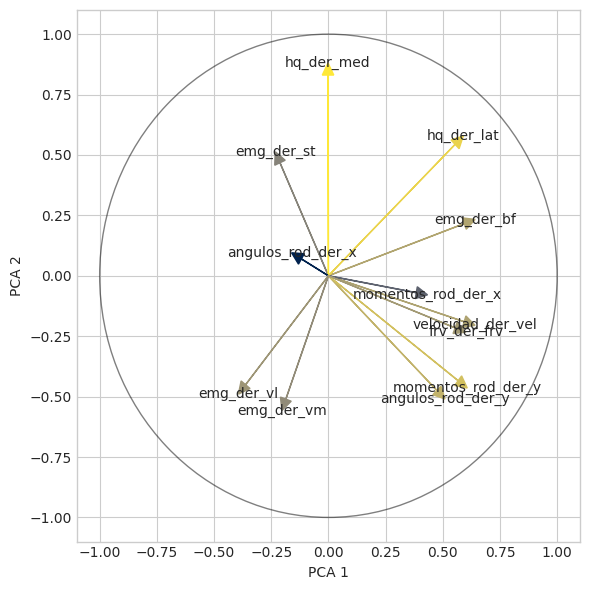

Grafico de las ejecuciones de los movimientos
Color de los puntos de acuerdo con la variable: lesion_rodilla_ultimos_3_anos


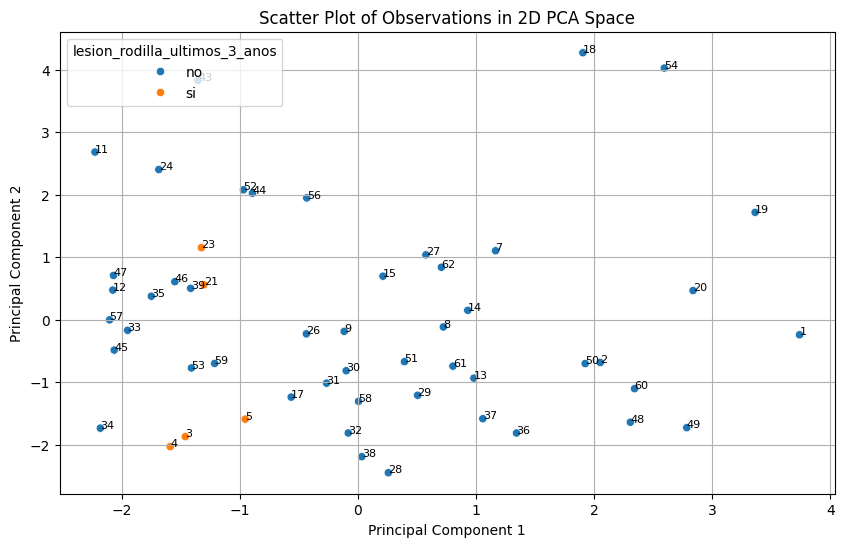

Grafico combinado: variables+movimientos


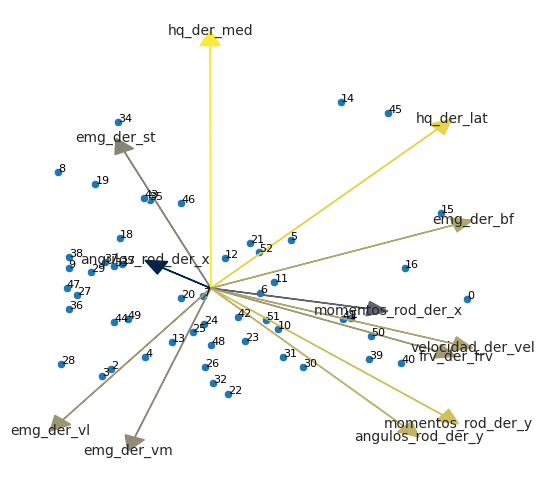

Variables que más contribuyen a PC1:
 ['hq_der_lat', 'velocidad_der_vel', 'emg_der_bf', 'momentos_rod_der_y', 'frv_der_frv', 'angulos_rod_der_y']


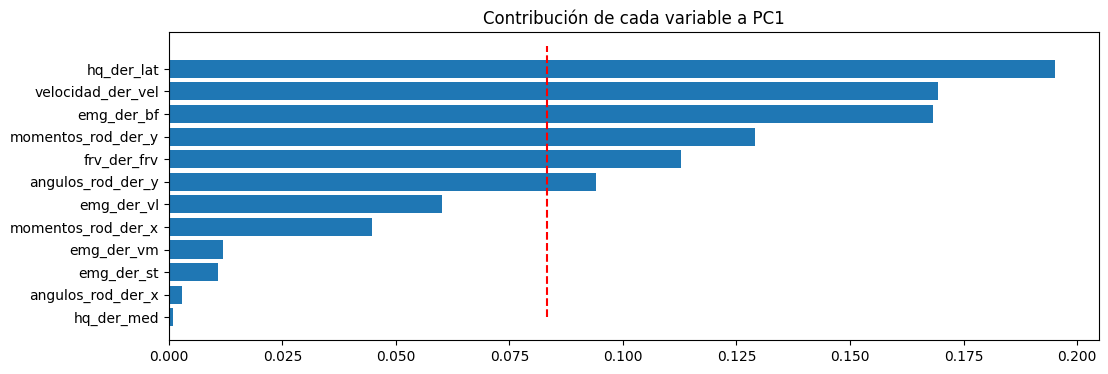

Variables que más contribuyen a PC2:
 ['hq_der_med', 'emg_der_vm', 'emg_der_st', 'emg_der_vl', 'hq_der_lat', 'angulos_rod_der_y']


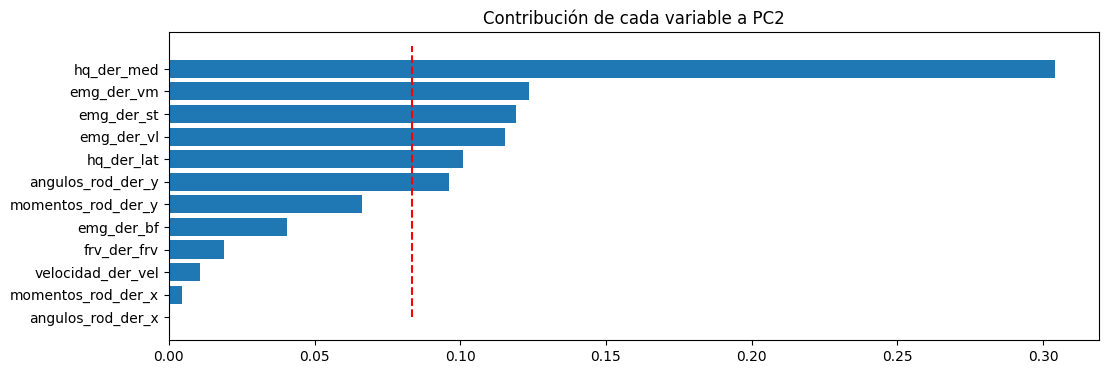

In [15]:
color_var = "lesion_rodilla_ultimos_3_anos"
_ = run_complete_pca(
    data=df_sit, 
    rowindex=df_sit["index"].tolist(),
    vars_use=vars_use, 
    color_var=color_var
)

### Vamos a ejecutar el PCA con las variables que mas contribuyen a la primera componente

Se adiciona `emg_der_vl` de acuerdo con el analisis realizado en conjunto

Explained variance ratio:  [0.4066125380043638, 0.23289097292756883]
Cumulative explained variance:  [0.40661254 0.63950351]
Transformed data shape: (53, 2)
Circulo de correlaciones de las variables


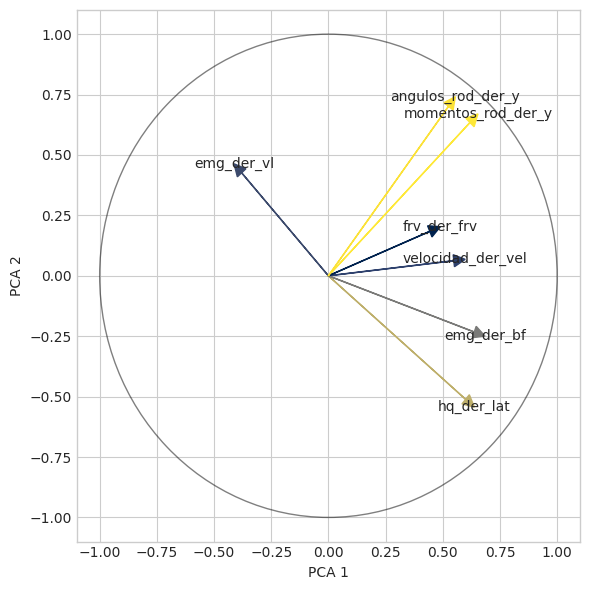

Grafico de las ejecuciones de los movimientos
Color de los puntos de acuerdo con la variable: lesion_rodilla_ultimos_3_anos


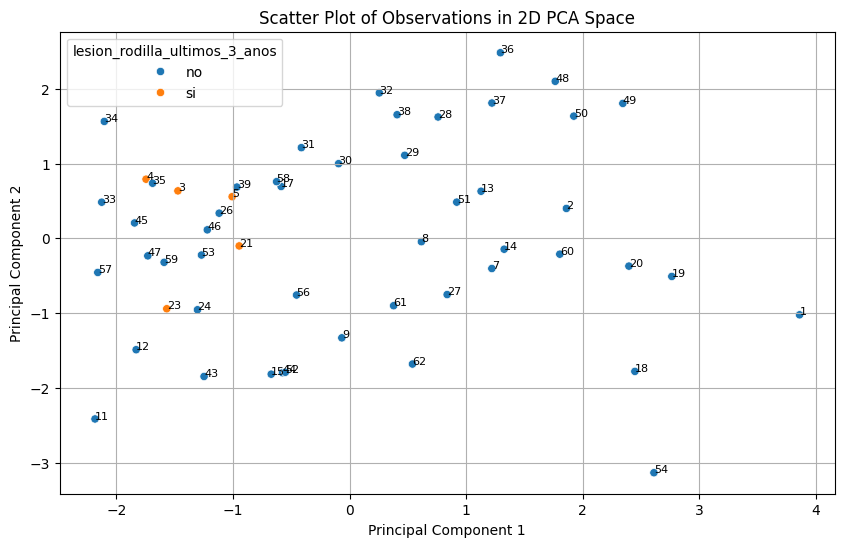

Grafico combinado: variables+movimientos


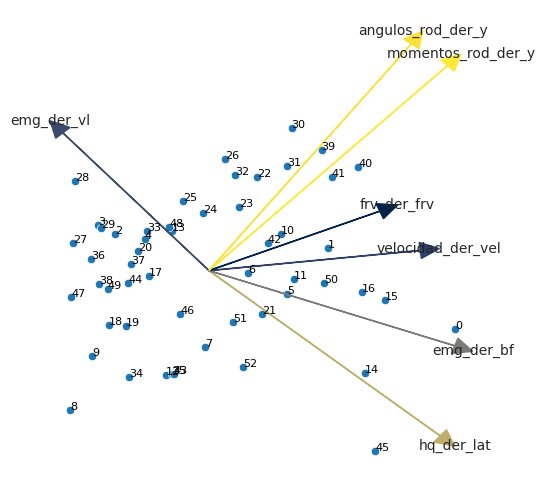

Variables que más contribuyen a PC1:
 ['hq_der_lat', 'emg_der_bf', 'momentos_rod_der_y', 'velocidad_der_vel']


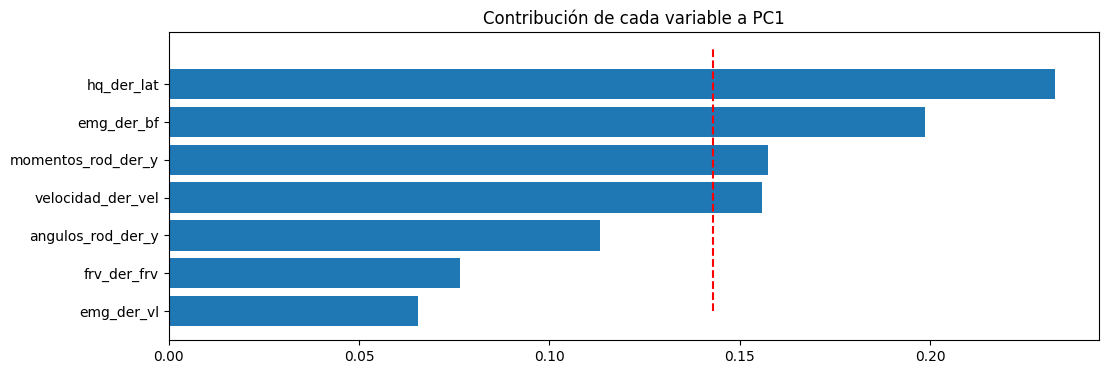

Variables que más contribuyen a PC2:
 ['angulos_rod_der_y', 'momentos_rod_der_y', 'emg_der_vl', 'hq_der_lat']


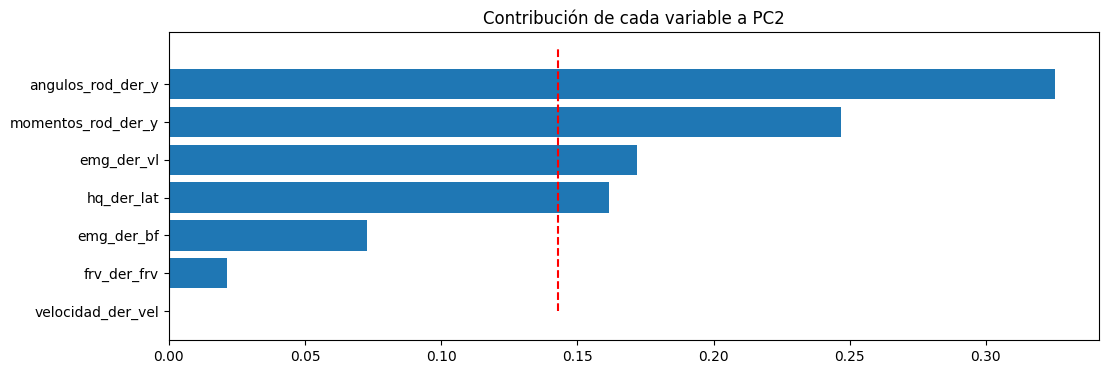

In [72]:
vars_use = [
    'emg_der_vl',

    'hq_der_lat', 
    'velocidad_der_vel', 
    'emg_der_bf', 
    'momentos_rod_der_y', 
    'frv_der_frv', 
    'angulos_rod_der_y'
]
color_var = "lesion_rodilla_ultimos_3_anos"
Xpca = run_complete_pca(
    data=df_sit, 
    vars_use=vars_use, 
    rowindex=df_sit["index"].tolist(),
    color_var=color_var
)

### Clusters con las variables seleccionadas para identificar grupos de movimientos:

Queremos identificar movimientos "bajo riesgo" y de "alto riesgo"

In [75]:
from sklearn.cluster import KMeans

clusterer = KMeans(n_clusters=2)
clusterer = clusterer.fit(Xpca)

df_cl = df_sit.copy()
df_cl["cluster"] = clusterer.labels_

print("Tamaño de los clusters: Cantidad de movimientos en cada cluster")
pd.concat([
    df_cl["cluster"].value_counts(),
    df_cl["cluster"].value_counts(normalize=True).round(4)
], axis="columns")

Tamaño de los clusters: Cantidad de movimientos en cada cluster


,count,proportion
cluster,,
1,29,0.5472
0,24,0.4528


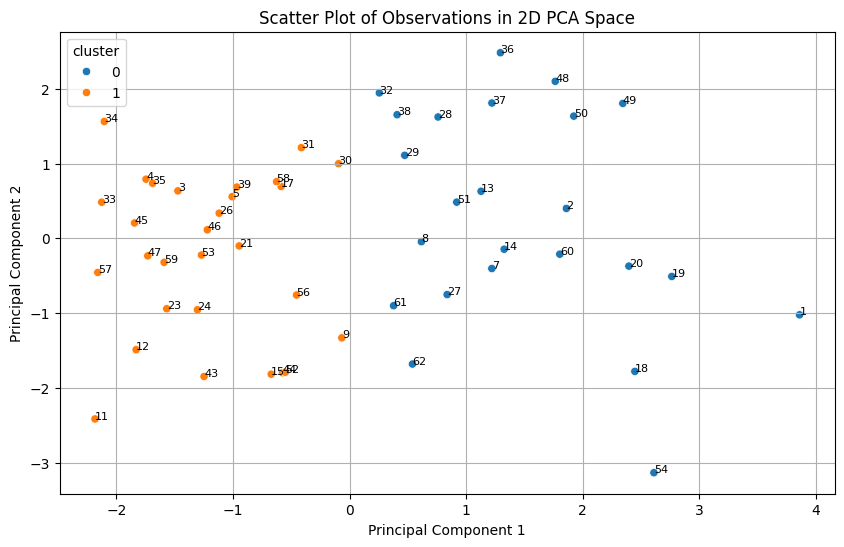

In [76]:
# Grafico de los clusters
color_var = "cluster"
color_arr = [str(x) for x in df_cl[color_var].values]
plot_individuals(
    Xpca=Xpca, 
    rowindex=df_sit["index"].tolist(),
    color=color_arr, 
    colorName=color_var
)

### Caracterizacion de los clusters

In [81]:
agg_dict = {
    x: ["min", "median", "mean", "max"] for x in total_vars
}
caract = df_cl.groupby(["cluster"]).agg(agg_dict).T
caract.columns = "cluster"+caract.columns.astype(str)
caract = caract.reset_index()
caract.columns.name = None
caract = caract.rename(columns={"level_0": "var", "level_1":"indicador"})

print("Caracteristicas con las variables seleccionadas")
display(caract[caract["var"].isin(vars_use)])
print("==="*20)
print("\n")
print("Caracteristicas con las variables restantes")
display(caract[~caract["var"].isin(vars_use)])

Caracteristicas con las variables seleccionadas


,var,indicador,cluster0,cluster1
0,emg_der_bf,min,0.060615,0.016256
1,emg_der_bf,median,0.178601,0.095380
2,emg_der_bf,mean,0.226980,0.107154
3,emg_der_bf,max,0.706295,0.397855
8,emg_der_vl,min,0.019875,0.051573
9,emg_der_vl,median,0.160485,0.241101
10,emg_der_vl,mean,0.163698,0.253655
11,emg_der_vl,max,0.256413,0.641626
16,hq_der_lat,min,0.366447,0.045352
17,hq_der_lat,median,1.228594,0.315210




Caracteristicas con las variables restantes


,var,indicador,cluster0,cluster1
4,emg_der_st,min,0.019476,0.015241
5,emg_der_st,median,0.084039,0.097329
6,emg_der_st,mean,0.097429,0.135663
7,emg_der_st,max,0.366472,0.389000
12,emg_der_vm,min,0.063162,0.022739
13,emg_der_vm,median,0.282242,0.290176
14,emg_der_vm,mean,0.330705,0.340427
15,emg_der_vm,max,0.927746,0.722751
20,hq_der_med,min,0.037817,0.081955
21,hq_der_med,median,0.296247,0.410988


In [78]:
# mayor momento en x, mas flexión
# mayor hq lateral mas riesgo (>1 mas riesgo). Entre mas cerca a 1 mejor.
# bf mas activacion  del hisquiotivial y menor activacion del musco vasco lateral (vl)

In [46]:
# print todas las variables
# print del proceso con las variables seleccionadas

---